# Setup

## Instructions
1. Download this notebook, and open in it in Jupyer, JupyerLab, VSCode, etc.

Set the following environment variable before loading any packages. This will make sure Octofitter can take advantage of all available threads on your computer.

In [1]:
%env JULIA_NUM_THREADS=auto

env: JULIA_NUM_THREADS=auto


The first time you import octofitterpy, we will automatically install Julia (via JuliaUp) and compile Octofitter.jl in a self-contained environment. Subsequent imports will be faster.

In [2]:
import octofitterpy as octo

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected Jupyter notebook. Loading juliacall extension. Set `OCTOFITTERPY_AUTOLOAD_EXTENSIONS=no` to disable.


# Fit Relative Astrometry

We start by defining a likelihood object for our data, in this case relative astrometry of the planet.

In [3]:
astrom_like = octo.PlanetRelAstromLikelihood(
    # MJD
    epoch = [50000,50120,50240,50360,50480,50600,50720,50840],
    # delta RA, milliarcseconds (East is positive)
    ra = [-505.7,-502.5,-498.2,-492.6,-485.9,-478.1,-469.0,-458.8],
    # delta DEC, milliarcseconds (North is positive)
    dec = [-66.9,-37.4,-7.9,21.6,51.1,80.5,109.7,138.6],
    # Uncertainty on RA, milliarcseconds
    σ_ra = [10,10,10,10,10,10,10,10.0],
    # Uncertainty on DEC, milliarcseconds
	σ_dec = [10,10,10,10,10,10,10,10],
    # Corelation between RA and DEC uncertainties
	cor= [0,0,0,0,0,0,0,0.0]
)
astrom_like

PlanetRelAstromLikelihood Table with 6 columns and 8 rows:
     cor  σ_ra  σ_dec  ra      dec    epoch
   ┌───────────────────────────────────────
 1 │ 0.0  10.0  10     -505.7  -66.9  50000
 2 │ 0.0  10.0  10     -502.5  -37.4  50120
 3 │ 0.0  10.0  10     -498.2  -7.9   50240
 4 │ 0.0  10.0  10     -492.6  21.6   50360
 5 │ 0.0  10.0  10     -485.9  51.1   50480
 6 │ 0.0  10.0  10     -478.1  80.5   50600
 7 │ 0.0  10.0  10     -469.0  109.7  50720
 8 │ 0.0  10.0  10     -458.8  138.6  50840

If your dates aren't in MJD format, you might use one of these functions to convert:

**To convert dates:**
*  `octo.mjd("2020-01-01")` -> to MJD
*  `octo.years2mjd("2020.0")` -> to MJD
*  convert back: `octo.mjd2date(50000)` -> `datetime.date(1995, 10, 10)`



You could also define the astrometry using a separation & position angle format:
```python
# You can also use separation (milliarcseconds) and position angle (RADIANS):
astrom_like = octo.PlanetRelAstromLikelihood(
    # MJD
    epoch = [50000,50120],
    # separation from star, milliarcseconds (East is positive)
    sep = [505.7,600.1],
    # position angle, RADIANS (!!) (NOT DEGREES)
    pa = [0.0,0.4,],
    # Uncertainty on sep, milliarcseconds
    σ_sep = [10,10],
    # Uncertainty on pa, RADIANS
	σ_pa = [0.01,0.01],
    # Corelation between PA and SEP uncertainties
    cor= [0,0.2]
)
```

We now define the planet component of our model. We specify a name, an orbital basis, our priors, and list any likelihood objects.

Note! Change the reference epoch provided to `θ_at_epoch_to_tperi` from 50000 to one where your astrometry is defined. This is critical for good performance.

In [ ]:
planet_b = octo.Planet(
    name="b",
    basis="Visual{KepOrbit}",
    priors=
    """            
        a ~ LogUniform(0.1, 500)
        e ~ Uniform(0.0, 0.99)
        i ~ Sine()
        ω ~ UniformCircular()
        Ω ~ UniformCircular()
        θ ~ UniformCircular()
        tp = θ_at_epoch_to_tperi(system,b,50000) # use MJD epoch of your data here!!
    """,
    likelihoods=[astrom_like]
)

Now we define our system, containing our planet. We provide it with a name (used to specofy the output file names and plot legends), our priors, a list of lieklihood objects for the system as a whole (eg proper motion anomaly, radial velocity), and a list of companion models.

In [ ]:
# The name of your system determines the output file names
sys = octo.System(
    name="HIP100123",
    priors = 
    """
        M ~ truncated(Normal(1.2, 0.1), lower=0)
        plx ~ truncated(Normal(50.0, 0.02), lower=0)
    """,
    likelihoods=[],
    companions=[planet_b]
)

We then compile our model. There are a few options for this function (for example, you can select the autodiff backend), but the defaults are reasonable.

In [ ]:
model = octo.LogDensityModel(sys)

We now fit the model. By default this uses a Hamiltonian Monte Carlo sampler with 1000 steps of adaptation (discarded) and 1000 iterations. You can pass eg. `adaptation=5000, iterations=25000` if you would like more points for your plots.

In [ ]:
chain = octo.octofit(model)

[ Info: Determining initial positions and metric using pathfinder
[ Info: Sampling, beginning with adaptation phase...
Sampling 100%|███████████████████████████████| Time: 0:00:08
  iterations:                                   2000
  ratio_divergent_transitions:                  0.01
  ratio_divergent_transitions_during_adaption:  0.04
  n_steps:                                      255
  is_accept:                                    true
  acceptance_rate:                              0.9954479747311628
  log_density:                                  -55.60667306996226
  hamiltonian_energy:                           61.47599423626976
  hamiltonian_energy_error:                     -0.23148414694338726
  max_hamiltonian_energy_error:                 -0.32535091280723805
  tree_depth:                                   7
  numerical_error:                              false
  step_size:                                    0.021744881924478047
  nom_step_size:                             

Sampling report for chain:
mean_accept                 = 0.8840878716820828
ratio_divergent_transitions = 0.023
mean_tree_depth             = 6.781
max_tree_depth_frac         = 0.0
gradient_evaluations        = 338388


**Long runtimes indiciate an error in your model**

The orbit fitting should take <30 s for this example. If you find it takes much longer on your code, double check the model and priors. Is the epoch you specified for `tperi` the same as your data? 

**Numerical errors indicate a problem with sampling**
If you see a report that numerical errors were encountered during sampling, the results may not be statistically valid. You could re-try sampling, or investigate your model for errors.

We can now display our results

In [ ]:
chain

Chains MCMC chain (1000×28×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 11.41 seconds
Compute duration  = 11.41 seconds
parameters        = M, plx, b_a, b_e, b_i, b_ωy, b_ωx, b_Ωy, b_Ωx, b_θy, b_θx, b_ω, b_Ω, b_θ, b_tp
internals         = n_steps, is_accept, acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt, loglike, logpost, tree_depth, numerical_error

Summary Statistics
  parameters         mean          std       mcse    ess_bulk   ess_tail       ⋯
      Symbol      Float64      Float64    Float64     Float64    Float64   Flo ⋯

           M       1.1895       0.0994     0.0047    443.6844   486.9767    0. ⋯
         plx      49.9992       0.0201     0.0006   1031.4517   676.4312    0. ⋯
         b_a      13.7446       5.2255     0.5807     87.8989   112.5651    1. ⋯
         b_e       0.1867       0.134

If you wish to save this summary table to a text file, you can convert it to a string like so:

In [ ]:
summary_str = repr(chain)

The chain itself can be saved to a FITS table like so:

In [ ]:
octo.savechain("mychain.fits", chain)

And restored from a FITS table like so:

In [ ]:
restored_chain = octo.loadchain("mychain.fits")

## Plotting

Use the `octoplot` function to generate plots. You can use keyword arguments (see documentation) to control which output panels appear. By default, they will be chosen automatically based on the kinds of data likelihoods you supply to the model.

The output is automatically saved to a PNG file in your current folder, with a name based on the name of the System you created.
You can also customize this using the `fname` argument (see docs for more details). You can change the image format (eg to PDF) by changing the file name extension.

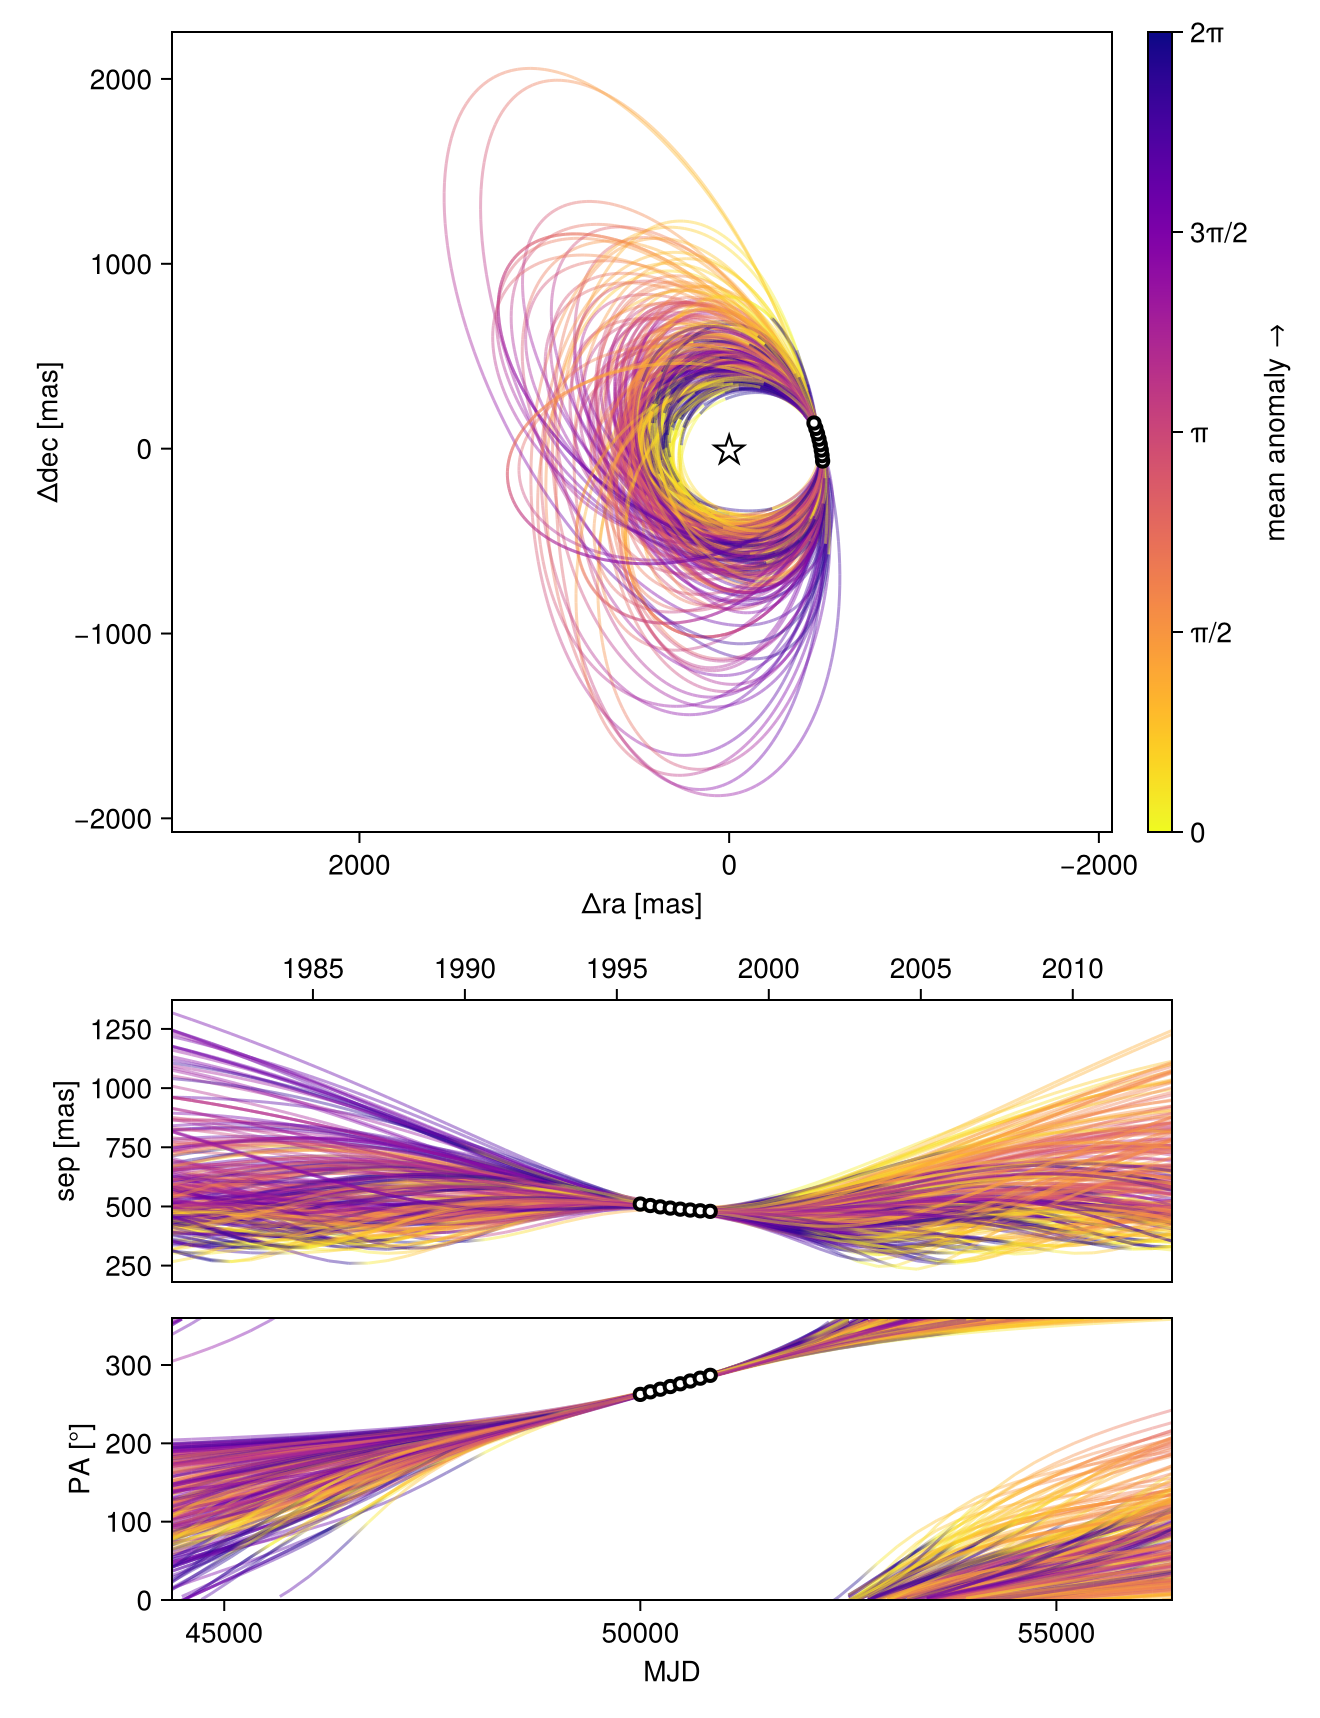

In [ ]:
octo.octoplot(model,chain)

The `octocorner` function makes a corner plot using the `pairplots` library. Optionaly set `small=False` to see all variables. The PNG file will automatically be saved to your current directory using a file name based on the System name you provided, or you can override using the `fname` argument (and change the output image format eg to pdf).
The documentation page lists additional arguments that can be used to control the appearance. 

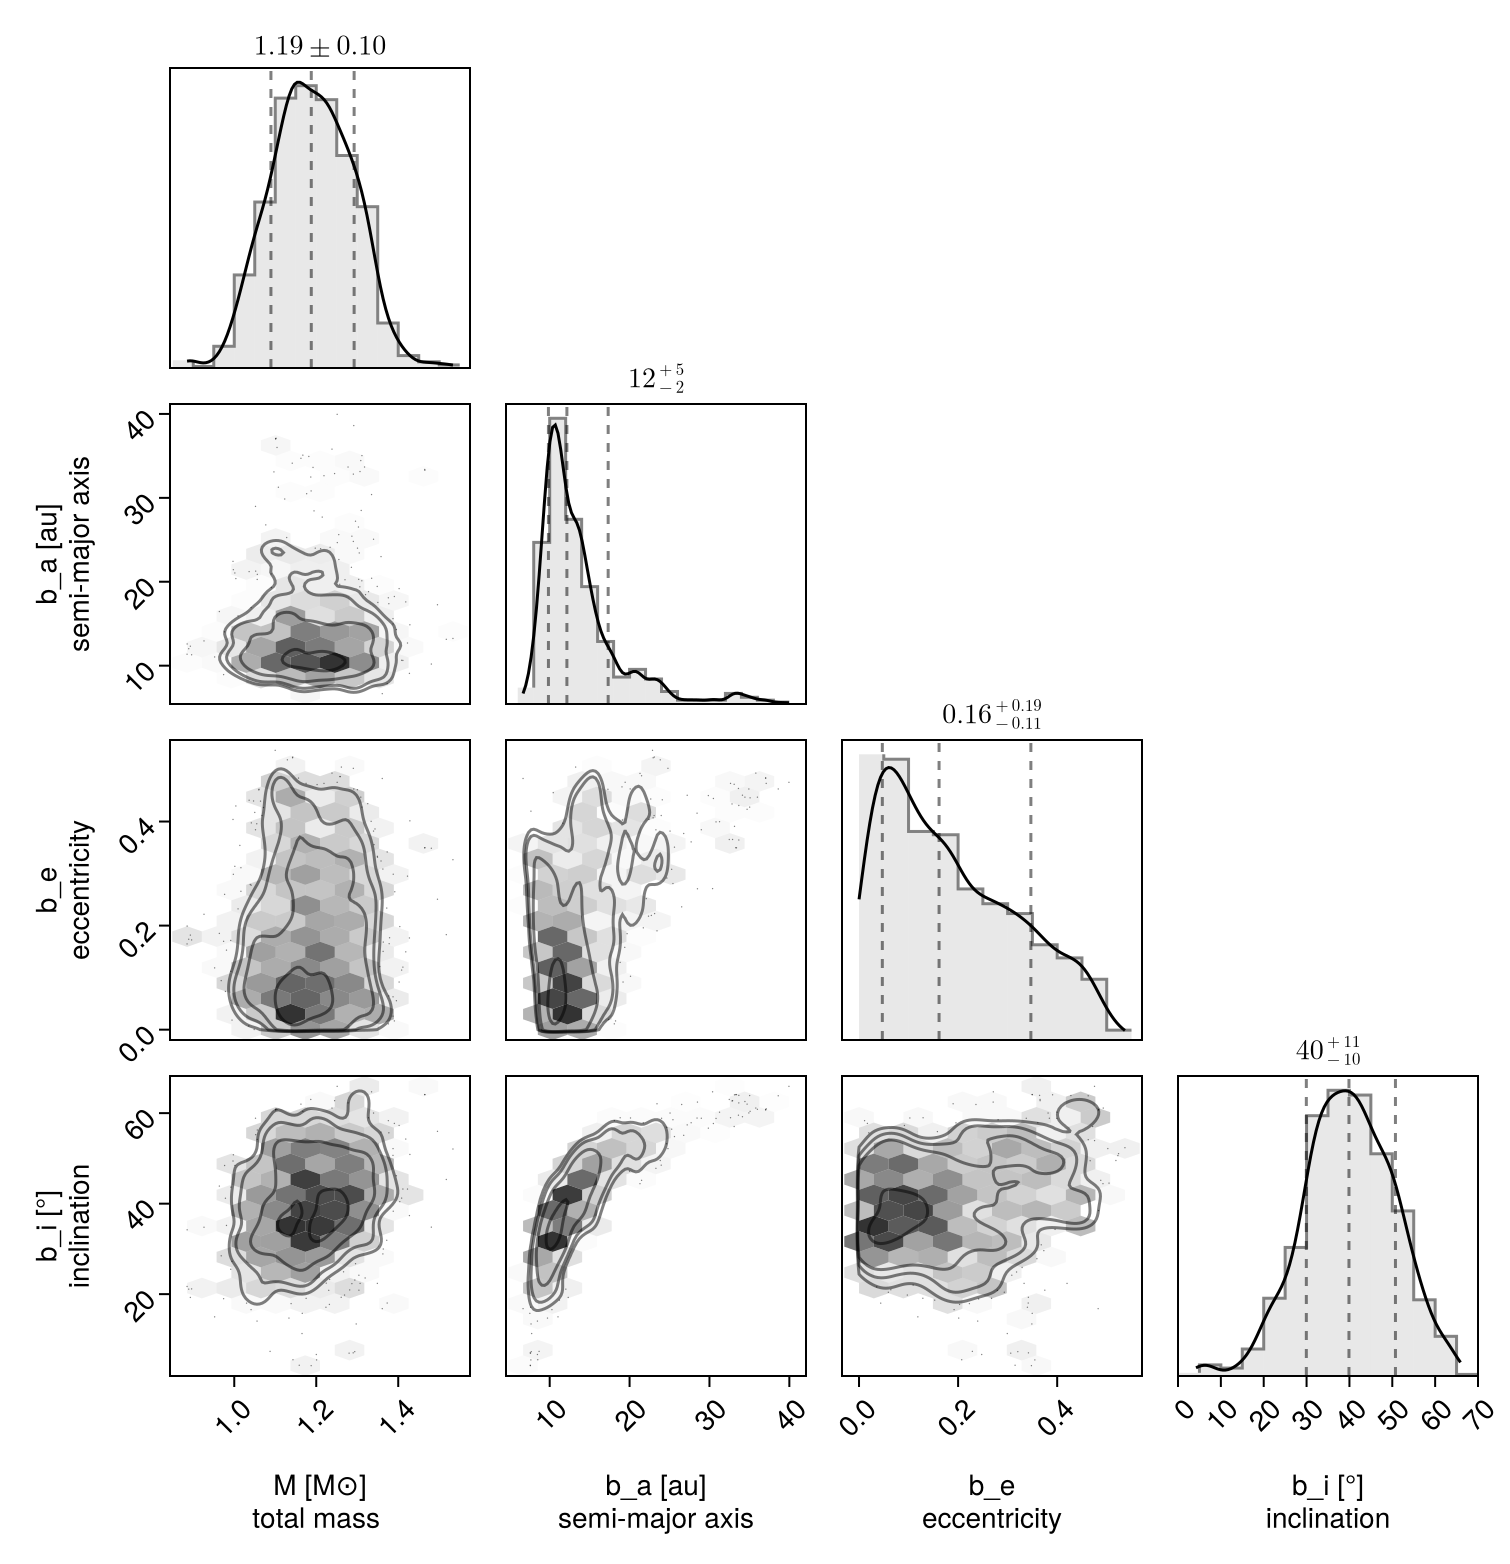

In [ ]:
octo.octocorner(model,chain,small=True)

## Fit Relative Astrometry and HGCA

Octofitter.jl supports fitting orbit models to astrometric motion in the form of GAIA-Hipparcos proper motion anomaly (HGCA; [https://arxiv.org/abs/2105.11662](https://arxiv.org/abs/2105.11662)).
These data points are calculated by finding the difference between a long term proper motion of a star between the Hipparcos and GAIA catalogs, and their proper motion calculated within the windows of each catalog. This gives four data points that can constrain the dynamical mass & orbits of planetary companions (assuming we subtract out the net trend).

If your star of interest is in the HGCA, all you need is it's GAIA DR3 ID number. You can find this number by searching for your target on [SIMBAD](http://simbad.cds.unistra.fr).

For this tutorial, we will examine the star and companion [HD 91312 A & B](https://arxiv.org/abs/2109.12124) discovered by SCExAO. We will use their published astrometry and proper motion anomaly extracted from the HGCA.

The first step is to find the GAIA source ID for your object. For HD 91312, SIMBAD tells us the GAIA DR3 ID is `756291174721509376`.

You can add a Hipparcos-GAIA proper motion anomally likelihood function by following these examples. You will need to add a `mass` variable to the planet, and `pmra` and `pmdec` (mas/yr) parameters to the system.

In [4]:
astrom_like = octo.PlanetRelAstromLikelihood(
    # MJD
    epoch = [57737.0,57824.0,57825.0,58157.0,58450.0,58467.0],
    # delta RA, milliarcseconds (East is positive)
    ra = [133.0, 126.0, 127.0, 83.0, 58.0, 56.0],
    # delta DEC, milliarcseconds (North is positive)
    dec = [-174.0, -176.0, -172.0, -133.0, -122.0, -104.0],
    # Uncertainty on RA, milliarcseconds
    σ_ra = [7.0, 4.0, 4.0, 10.0, 10.0, 8.0],
    # Uncertainty on DEC, milliarcseconds
	σ_dec = [7.0, 4.0, 4.0, 10.0, 20.0, 8.0],
    # Corelation between RA and DEC uncertainties
	cor= [0,0,0,0,0,0]
)
    

planet_b = octo.Planet(
    name="b",
    basis="Visual{KepOrbit}",
    priors=
    """            
        a ~ LogUniform(0.1, 500)
        e ~ Uniform(0.0, 0.99)
        i ~ Sine()
        ω ~ UniformCircular()
        Ω ~ UniformCircular()
        θ ~ UniformCircular()
        tp = θ_at_epoch_to_tperi(system,b,50000) # use MJD epoch of your data here!!
        mass ~ LogUniform(1, 1000)
    """,
    likelihoods=[astrom_like]
)

hgca_like = octo.HGCALikelihood(gaia_id=756291174721509376)
# The name of your system determines the output file names
sys = octo.System(
    name="HIP100123_with_pma",
    priors=
    """
        M ~ truncated(Normal(1.6, 0.1), lower=0)
        plx ~ gaia_plx(gaia_id=756291174721509376)
        pmra ~ Normal(0,1000)
        pmdec ~ Normal(0,1000)
    """,
    likelihoods=[hgca_like],
    companions=[planet_b]
)
model = octo.LogDensityModel(sys)

We can now fit the model using `octo.octofit` as before

In [ ]:
chain = octo.octofit(model)

[ Info: Determining initial positions and metric using pathfinder
[ Info: Sampling, beginning with adaptation phase...
Sampling 100%|███████████████████████████████| Time: 0:00:40
  iterations:                                   2000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.04
  n_steps:                                      255
  is_accept:                                    true
  acceptance_rate:                              0.995319480660646
  log_density:                                  -86.98665792485272
  hamiltonian_energy:                           92.79243204547895
  hamiltonian_energy_error:                     -0.019498685528191118
  max_hamiltonian_energy_error:                 -0.09837459578079688
  tree_depth:                                   8
  numerical_error:                              false
  step_size:                                    0.011248626587005
  nom_step_size:                                0

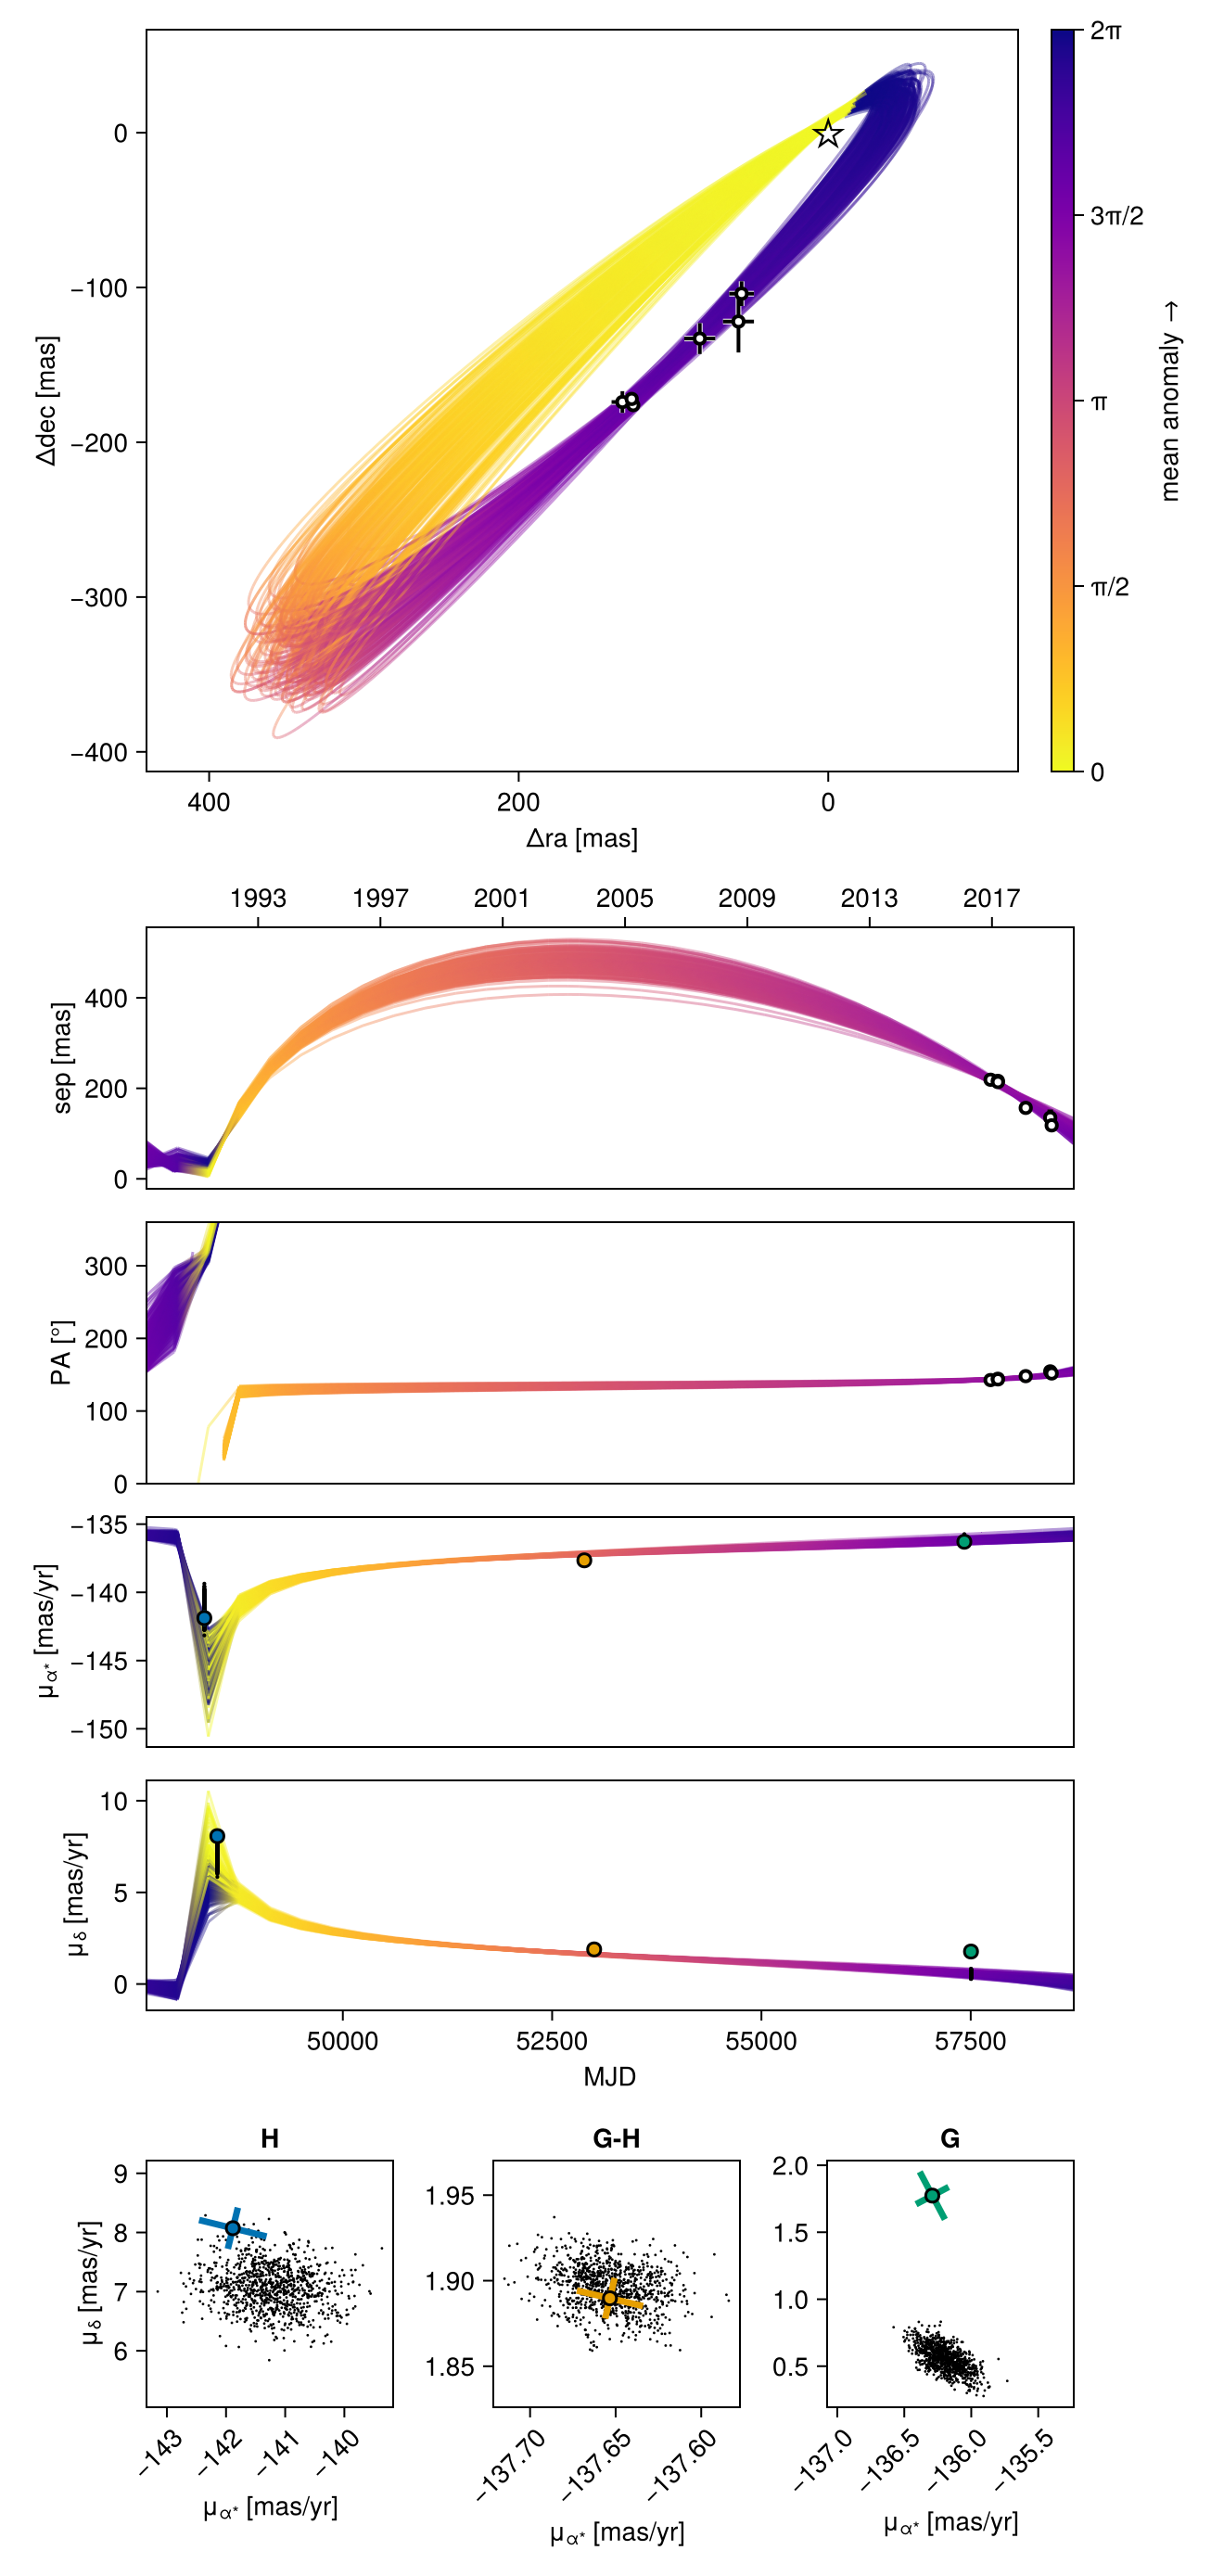

In [ ]:
octo.octoplot(model,chain)

The above will work well if you have decent orbital coverage. If you don't (like in this case), an HGCA posterior is could bemulti-modal. 
To sample from a multi-modal, posterior, try using Pigeons non-reversible parallel tempered sampling. This is more robust, but somewhat slower.

We can do that as follows:

In [ ]:
chain, pt = octo.octofit_pigeons(model, n_rounds=6)

┌ Info: Determined draw using pathfinder
│   chain_no = 1
└   initial_logpost = -456.123589501015
┌ Info: Determined draw using pathfinder
│   chain_no = 2
└   initial_logpost = -87853.21407733232
┌ Info: Determined draw using pathfinder
│   chain_no = 3
└   initial_logpost = -161595.64624820987
┌ Info: Determined draw using pathfinder
│   chain_no = 4
└   initial_logpost = -25383.57032523127
┌ Info: Determined draw using pathfinder
│   chain_no = 5
└   initial_logpost = -332.16487083831004
┌ Info: Determined draw using pathfinder
│   chain_no = 6
└   initial_logpost = -5308.589711740497
┌ Info: Determined draw using pathfinder
│   chain_no = 7
└   initial_logpost = -409.23486747566034
┌ Info: Determined draw using pathfinder
│   chain_no = 8
└   initial_logpost = -25941.823271519548
┌ Info: Determined draw using pathfinder
│   chain_no = 9
└   initial_logpost = -25497.012137869635
┌ Info: Determined draw using pathfinder
│   chain_no = 10
└   initial_logpost = -25514.549599931837
┌ In

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  scans     restarts      Λ        Λ_var      time(s)    allc(B)  log(Z₁/Z₀)   min(α)     mean(α)    min(αₑ)   mean(αₑ) 
────────── ────────── ────────── ────────── ────────── ────────── ────────── ────────── ────────── ────────── ──────────
        2          0          7       3.96       11.4   3.85e+08  -5.36e+07          0      0.646      0.903      0.944 
        4          0       2.75       3.37      0.271   2.32e+07  -1.53e+07          0      0.803      0.884      0.935 
        8          0       7.62        5.2      0.217   8.89e+06  -5.22e+06          0      0.587       0.91      0.932 
       16          0       11.5       7.84       0.46   1.76e+07  -6.45e+04          0      0.376      0.917      0.933 
       32          0       10.6       9.76      0.973    3.5e+07   -5.9e+04          0      0.342      0.914      0.933 
       64          0       11.4 

The number of iterations will be `2**n_rounds`, .i.e n_rounds=10 will generate 1024 posterior samples. The default number of chains used for tempering is 16, with an additional 16 "variational" chains.

Unlike HMC (`octo.octofit`), pigeons tempered sampling (`octo.octofit_pigeons`) can be resumed to add more rounds (and samples) as follows:

In [ ]:
octo.increment_n_chains(pt, 4) # add four more rounds
chain, pt = octo.octofit_pigeons(pt)

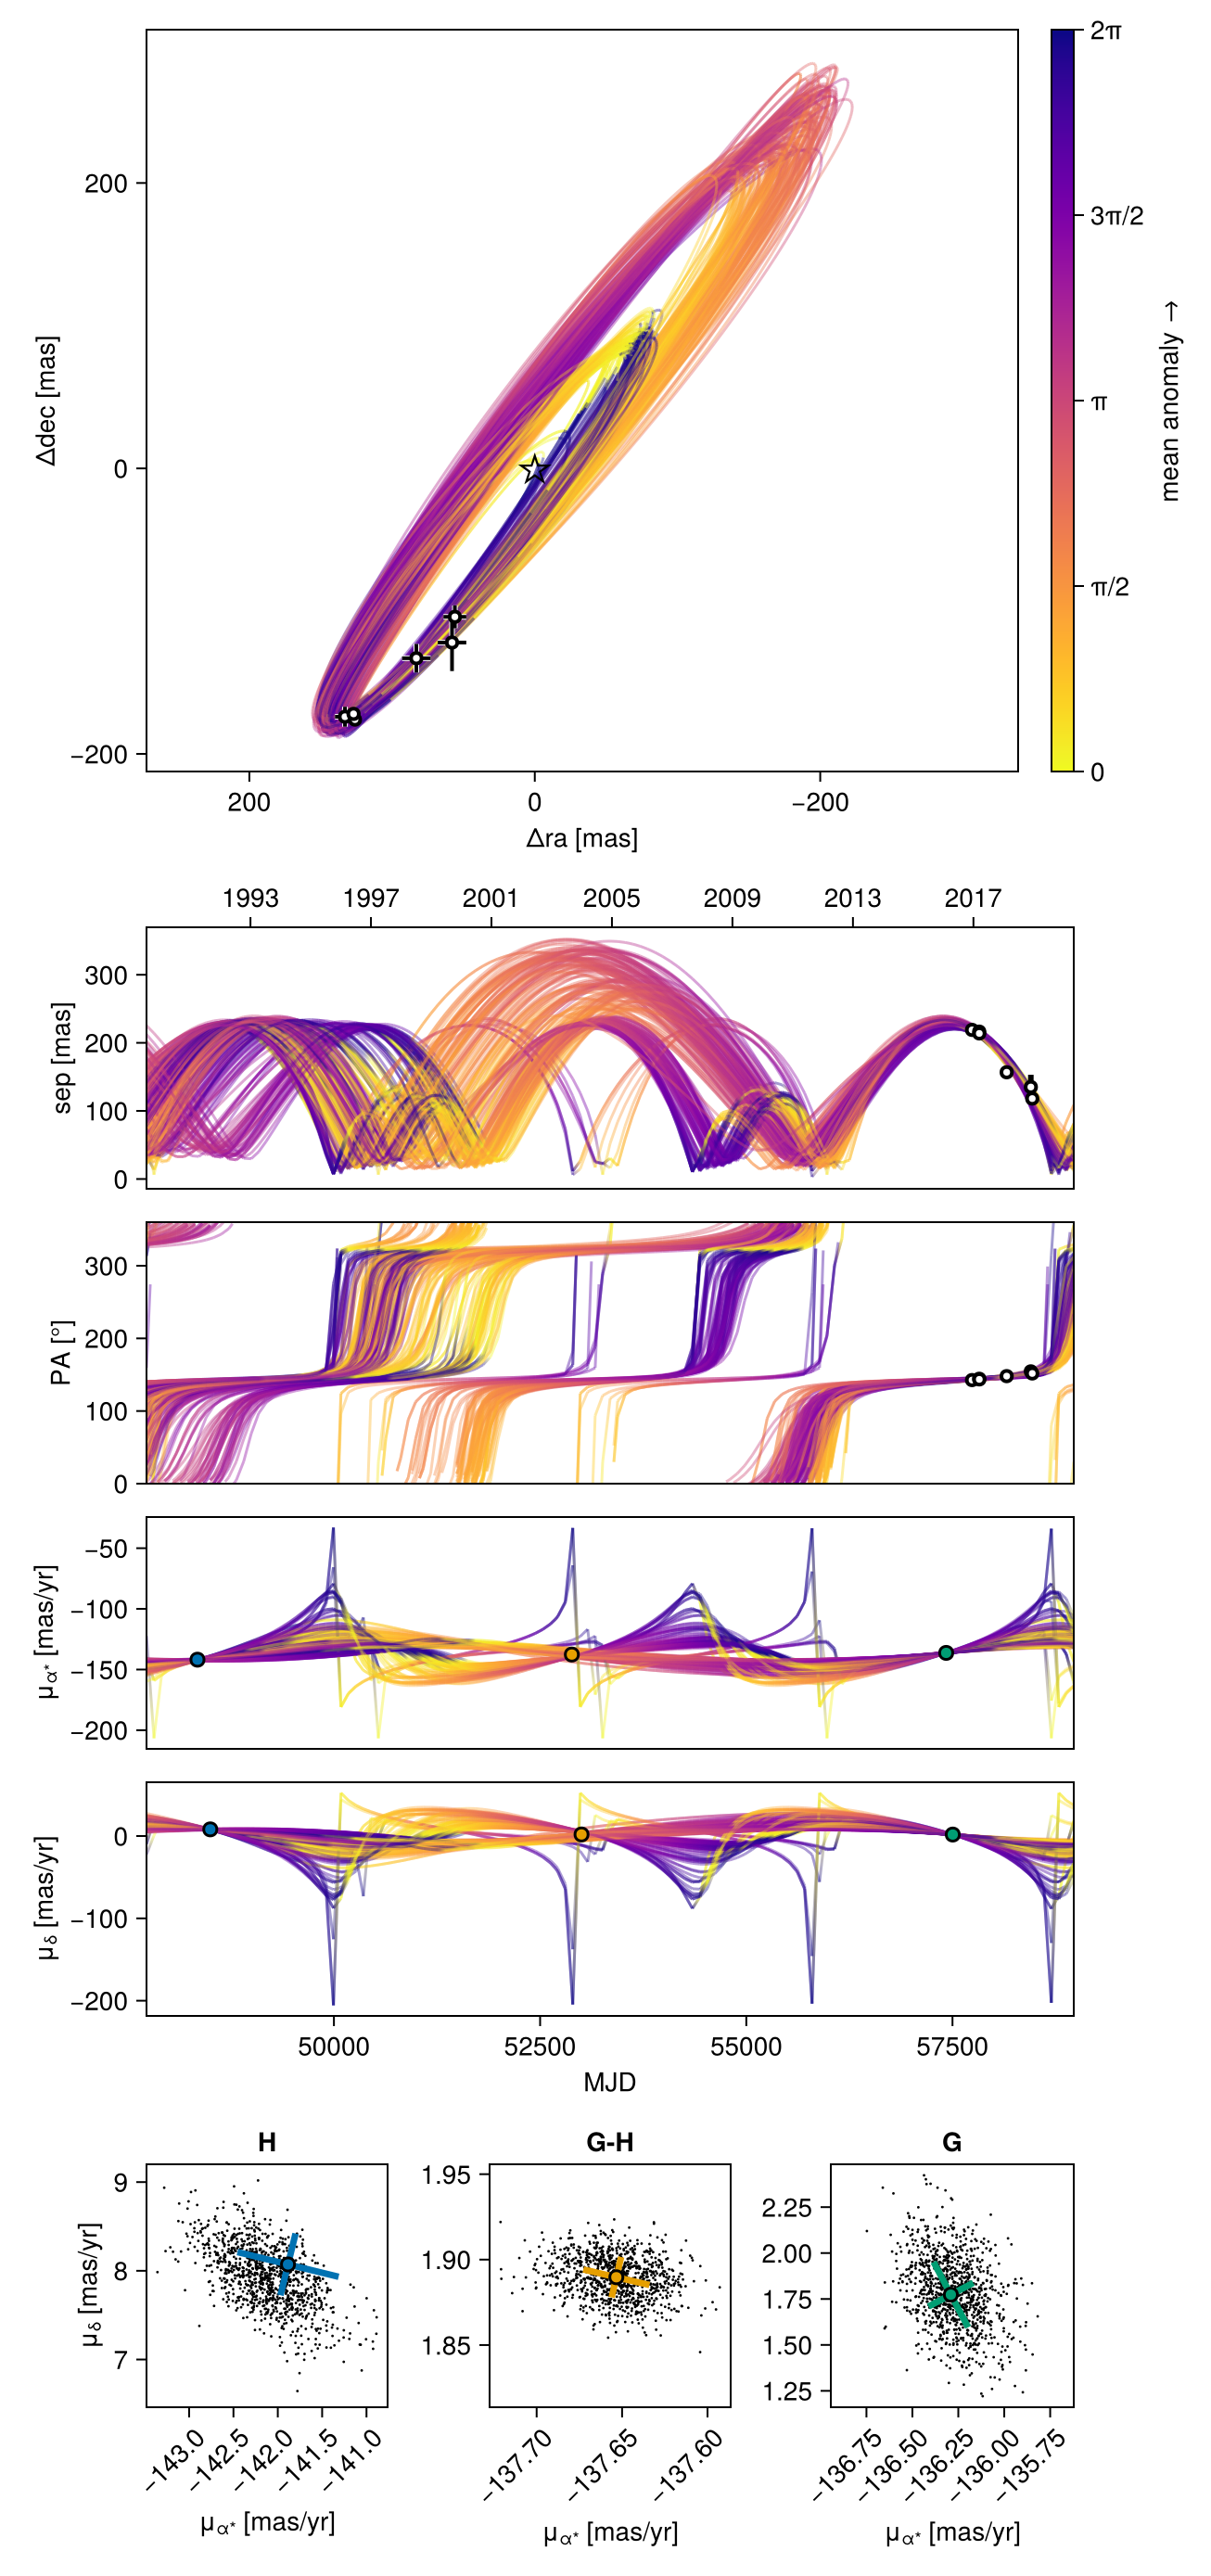

In [ ]:
octo.octoplot(model,chain)

Much better!

## Adding Radial Velocity

We will now add a few radial velocity points for the star, taken in an interial reference frame (absolute radial velocity).

The paper by Borgniet et al (2019) contains some RV points for this target that were also used by the SCExAO detection. Unfortunately they were not finally uploaded to a public server, but we can guess them from Figure 8 as follows:

In [3]:
rv_star_like = octo.StarAbsoluteRVLikelihood(
    epoch=[ 54899.5],#, 55249.5, 57499.5],
    # m/s, positive away from the observer
    rv = [1200],#, 600, -900] ,
    # m/s
    σ_rv = [1000],#,1000,1000] ,
    # Instrument number
    inst_idx = [1],#, 1, 1],
)

We can update our System model to add the new data. We also add variables for the RV offset and jitter for each instrument number (we only have 1 in this example).

In [11]:
planet_b = octo.Planet(
    name="b",
    basis="Visual{KepOrbit}",
    priors=
    """            
        a ~ LogUniform(0.1, 500)
        e ~ Uniform(0.0, 0.5)
        i ~ Sine()
        ω ~ UniformCircular()
        Ω ~ UniformCircular()
        θ ~ UniformCircular()
        tp = θ_at_epoch_to_tperi(system,b,50000) # use MJD epoch of your data here!!
        mass ~ LogUniform(1, 1000)
    """,
    likelihoods=[astrom_like]
)

hgca_like = octo.HGCALikelihood(gaia_id=756291174721509376)
# The name of your system determines the output file names
sys = octo.System(
    name="HIP100123_with_pma",
    priors=
    """
        M ~ truncated(Normal(1.6, 0.1), lower=0)
        plx ~ gaia_plx(gaia_id=756291174721509376)
        pmra ~ Normal(0,1000)
        pmdec ~ Normal(0,1000)

        rv0_1 ~ Normal(0, 5000)
        jitter ~ truncated(Normal(0, 5000),lower=0)
    """,
    likelihoods=[hgca_like, rv_star_like],
    companions=[planet_b]
)
model = octo.LogDensityModel(sys,verbosity=4)

[ Info: Preparing model
┌ Info: Determined number of free variables
└   D = 15
┌ Info: Tuning autodiff
│   chunk_size = 15
└   t = 1.3e-5
┌ Info: Selected auto-diff chunk size
└   ideal_chunk_size = 15


ℓπcallback(θ): 0.000022 seconds (8 allocations: 368 bytes)
∇ℓπcallback(θ): 0.000031 seconds (8 allocations: 624 bytes)


In [12]:
chain, pt = octo.octofit_pigeons(model, n_rounds=2)

In [ ]:
octo.octoplot(model,chain)

We can plot the RV orbit against the data in more detail using `rvpostplot` function. This visualizes a single orbit sample, by default the maximum *a-posteriori* sample.

In [ ]:
octo.rvpostplot(model,chain)